In [1]:
# 1. 라이브러리 불러오기
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# 2. 데이터 불러오기 및 전처리
df = pd.read_csv("clean_NYC_v1.csv")
df.drop(df[df['days_since_review'] == 9999].index, inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)


In [3]:
# 3. 타겟 생성 (log_price 기반 price_class)
df['price_class'] = pd.qcut(df['log_price'], q=3, labels=['low', 'medium', 'high'])


In [4]:
# 4. 특성 및 타겟 지정
X = df[['number_of_reviews', 'reviews_per_month', 'minimum_nights',
        'latitude', 'longitude', 'availability_365', 'calculated_host_listings_count'] +
       [col for col in df.columns if col.startswith('neighbourhood_group_')] +
       [col for col in df.columns if col.startswith('room_type_')]]

y = df['price_class']
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [5]:
# 5. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [6]:
# 6. 하이퍼파라미터 튜닝
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 15],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'max_depth': [10, 15],
                         'min_samples_leaf': [1, 2],
                         'n_estimators': [100, 150]},
             scoring='f1_macro', verbose=1)

In [7]:
# 7. 모델 평가
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("최적 하이퍼파라미터:")
print(grid.best_params_)
print("\n분류 성능 리포트:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


최적 하이퍼파라미터:
{'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 2, 'n_estimators': 150}

분류 성능 리포트:
              precision    recall  f1-score   support

        high       0.74      0.74      0.74      2565
         low       0.81      0.82      0.81      2755
      medium       0.56      0.56      0.56      2389

    accuracy                           0.71      7709
   macro avg       0.70      0.70      0.70      7709
weighted avg       0.71      0.71      0.71      7709



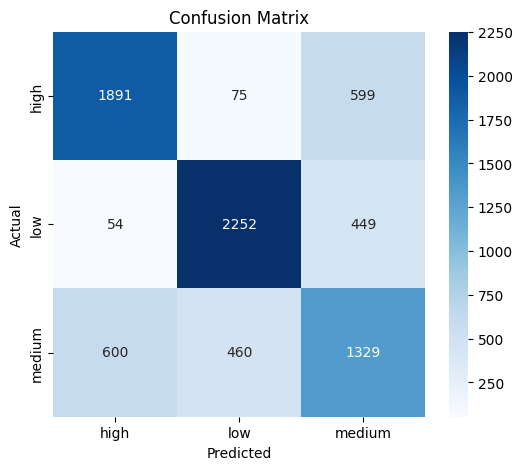

In [8]:
# 8. 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

roc curve 넣어보기

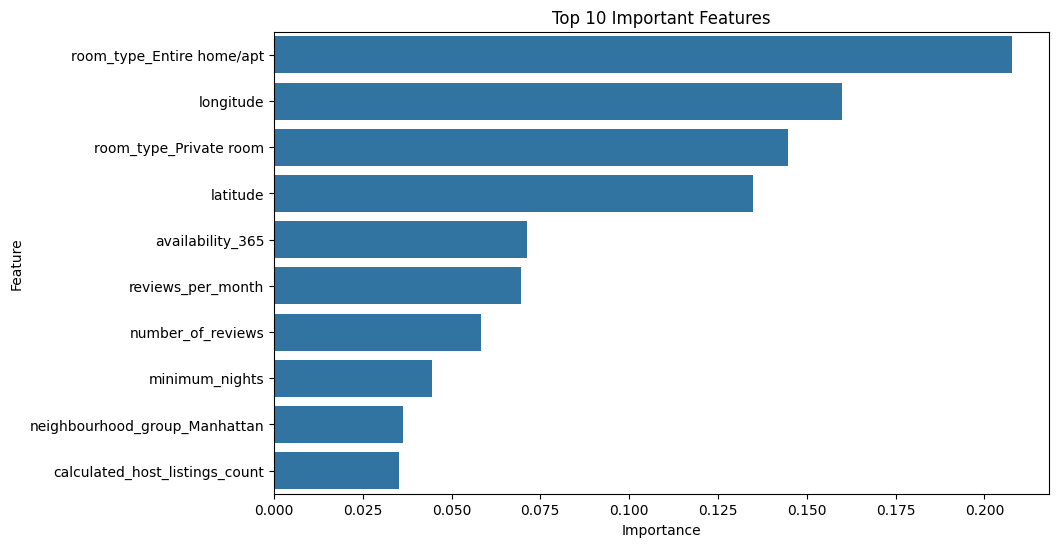

In [9]:
# 9. 특성 중요도 시각화
importances = best_model.feature_importances_
features = X.columns
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title('Top 10 Important Features')
plt.show()